# Predicting drug-drug interactions with GraphSAGE + JK-Net

*A final project by Blaž Erzar, Bernard Sovdat, and Klemen Vovk for the Stanford [CS224W class](https://web.stanford.edu/class/cs224w/) in the Fall of 2021.*

Graph neural networks are often thought of as hard and challenging subject. Our goal in this colab is to explain and show a real world use case of GNNs.

We are assuming the readers are familiar with machine learning and deep learning concepts and a working knowledge of Pytorch is required to understand the programming examples.


## Introduction

If you take several different medicines, see more than one doctor, or have certain health conditions, you and your doctors need to be aware of all the medicines you take. Doing so will help you to avoid potential problems such as drug interactions.

Drugs interacting in your body might make your drug less effective, increase the action of a particular drug, or cause unexpected side effects. Some drug interactions could even be harmful to the patient.

Drug interactions can be dangerous although side effects might seem harmless. For example, mixing a drug you take to help you sleep (a sedative) and a drug you take for allergies (an antihistamine) can slow your reactions and make driving a car or operating machinery dangerous.


## Dataset

Starting knowledge is given with the **ogbl-ddi** dataset from Open Graph Benchmark, which is a  collection of realistic, large-scale, and diverse benchmark datasets for machine learning on graphs.

This dataset is a homogeneous, unweighted, undirected graph, representing the drug-drug interaction network. Each node represents an FDA-approved or experimental drug. Edges represent interactions between drugs and can be interpreted as a phenomenon where the joint effect of taking the two drugs together is considerably different from the expected effect in which drugs act independently of each other.

The task at hand is to predict drug-drug interactions given information on already known drug-drug interactions. We want the model to rank true drug interactions higher than non-interacting drug pairs. Specifically, we rank each true drug interaction among a set of approximately 100,000 randomly-sampled negative drug interactions, and count the ratio of positive edges that are ranked at K-place or above (Hits@K).

## Code

Now lets start coding our model. First we need to import PyTorch which is already installed in Google Colab and get its version.

In [ ]:
import torch
print(torch.__version__)

After we get its version, we can install PyTorch Geometric (version needs to match PyTorch version printed above) and Open Graph Benchmark using pip.

In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install -q torch-geometric
!pip install ogb

### Parameters

First we will define the parameters that we will be using throughout the following code. These are parameters that we are using in our models and have been chosen to provide the best prediction accuracy.

In [ ]:
# Arguments
INPUT_DIM = 512
HIDDEN_DIM = 512
OUTPUT_DIM = 256
NUM_LAYERS = 3
DROPOUT = 0.5
LEARNING_RATE = 0.001
EPOCHS = 100
TEST_TRAIN_SAMPLES = 100000
BATCH_SIZE = 50000
RUNS = 5

### Importing data

We will be importing data from `ogb.linkproppred` using `PygLinkPropPredDataset`. Later we will also use `Evaluator` from the same module, which will allow us to evaluate our predictions using the **hits@K** measure. In our case K will be 20.

When we import the dataset, we transform it into a `SparseTensor` which allows us more efficient computing. Then we check which device is available, GPU or CPU, because we will be doing calculations on it. We recommend using GPU hardware accelerating, as it will provide much better performance.

Our dataset contains only one graph, which has 4267 nodes. We use `get_edge_split` method on the database object, to get the train, valid and test edges. From the train set we only sample `TEST_TRAIN_SAMPLES` edges which we will actually be using during evaluation. Because our graph is a `SparseTensor`, we first create `edge_index` from it, from which we then sample the edges that are randomly selected using `torch.randperm` function.


In [ ]:
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
import torch_geometric.transforms as T

# Import database
dataset = PygLinkPropPredDataset(name='ogbl-ddi', transform=T.ToSparseTensor())
print('obl-ddi dataset has', len(dataset), 'graphs')

# Check available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

# Get database graph
graph = dataset[0].to(device)
graph.num_nodes = 4267
print(graph)

# Get train, valid and test splits
split_edge = dataset.get_edge_split()

# Randomly sample edges for training accuracy
row, col, _ = graph.adj_t.coo()
edge_index = torch.stack([col, row], dim=0)

split_edge['train_acc'] = {}

idxs = torch.randperm(split_edge['train']['edge'].size(0))
idxs = idxs[:TEST_TRAIN_SAMPLES]
split_edge['train_acc']['edge'] = split_edge['train']['edge'][idxs]

### GraphSAGE layer

The first part of our model will be the GraphSAGE layer. This layer contains 2 `Linear` transformations. One is used on the current node embedding and the other on the aggregated embeddings of all the neighbours of the current node. We sum the results of these 2 transformations together and normalize them using `normalize` function from `torch.nn.functional`.

The transformation objects are defined in the constructor and the main forward propagation in the `forward` method. The `message` method returns the message for the current node, which in this case is simply the embedding of the node in the current layer. The `aggregate` method simply aggregates all the embeddings of all the neighbours for every node and then calculates their mean value. This is then returned from the `propagate` method call.

This layers can be written using the following mathematical notation:
$$
\mathbf{h}_v^k = \mathbf{W}_l \cdot \boldsymbol{h}_v^{k-1} + \mathbf{W}_r \cdot \text{MEAN}(\{\mathbf{h}_u^{k-1}, \forall u \in \mathcal N (v))\})
$$

Here $\mathbf{h}_v^k$ is the embedding of the node $v$ on the layer we are calculating, $\mathbf{W}_l$ and $\mathbf{W}_r$ are the `Linear` transforms. $\text{MEAN}$ takes the embeddings of all the neighbours of $v$, $\mathbf{h}_u^{k-1}$, on the previous layer and calculates their mean. This embeddings is then transformed and summed up with the transformed embedding of $v$ on the previous layer, $\boldsymbol{h}_v^{k-1}$.

In [ ]:
from torch_geometric.nn.conv import MessagePassing
from torch.nn import Linear
import torch.nn.functional as F
import torch_scatter

class GraphSAGE(MessagePassing):
  def __init__(self, input_dim, output_dim, bias=False):
    super().__init__()
    self.lin_l = Linear(input_dim, output_dim, bias=bias)
    self.lin_r = Linear(input_dim, output_dim, bias=bias)

    self.reset_parameters()
  
  def reset_parameters(self):
    self.lin_l.reset_parameters()
    self.lin_r.reset_parameters()
  
  def forward(self, x, edge_index, size=None):
    out = self.lin_r(self.propagate(edge_index, x=(x, x), size=size))
    out = self.lin_l(x) + out
    out = F.normalize(out)

    return out

  def message(self, x_j):
    return x_j
  
  def aggregate(self, inputs, index, dim_size = None):
    out = torch_scatter.scatter(inputs, index, self.node_dim, dim_size=dim_size, reduce='mean')
    return out
  

### GNN Stack

Now we will stack multiple GraphSAGE layers together to create our Graph Neural Network that will predict node embeddings. We will be implementing the following pipeline:
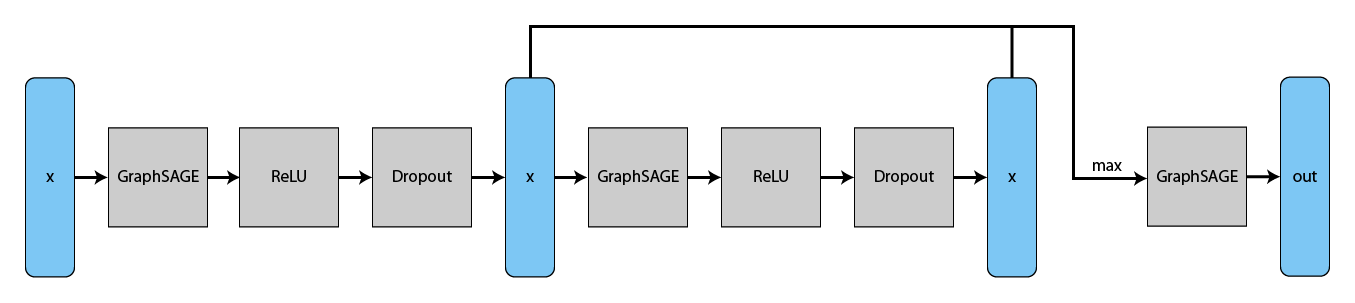

We do this by creating a class that extends `torch.nn.Module`. In the constructor we first create all the convolutional layers using `torch.nn.ModuleList`, where we are using GraphSAGE with `bias=True` for all of them. All the layers have the same parameters, except the first and last one, which have a different input or output dimension.

In the forward propagation step that is implemented in method `forward` we feed node embedding into a GraphSAGE layer, followed by a ReLU activation function and dropout for every layer except the last one. We are using dropout to prevent overfitting to our data and we are only using it during training, since `training=self.training`. For the last layer we only use GraphSAGE.

Here we also used an idea from the JK-Net (Jumping Knowledge Networks) paper. We save embedding at each layer into a list and feed the element wise maximum into the last GraphSAGE layer. This way we include skip connection to different layers and with max pooling we select the most informative layer for every embedding coordinate.



In [ ]:
class GNN(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
    super().__init__()
    
    self.num_layers = num_layers

    # Dropout probability
    self.dropout = dropout

    self.convs = torch.nn.ModuleList()
    # Add first layer
    self.convs.append(GraphSAGE(input_dim, hidden_dim, True))
    # Add hidden layers
    for _ in range(num_layers - 2):
      self.convs.append(GraphSAGE(hidden_dim, hidden_dim, True))
    # Add last layers
    self.convs.append(GraphSAGE(hidden_dim, output_dim, True))

  def reset_parameters(self):
    for conv in self.convs:
      conv.reset_parameters()

  def forward(self, x, adj_t):
    xs = []
    for i in range(self.num_layers - 1):
      x = self.convs[i](x, adj_t)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)
      xs.append(x)
    x = torch.stack(xs, dim=0)
    x = torch.max(x, dim=0)[0] 
    x = self.convs[-1](x, adj_t)
    
    return x


### Edge Predictor

After getting node embeddings we need to predict new links in the graph. We do this by implementing Multi Layer Perceptron that returns the probability for edges composed from node pairs in `x_i` and `x_j` that are parameters passed into the `forward` method. Here we will implement the following pipeline:
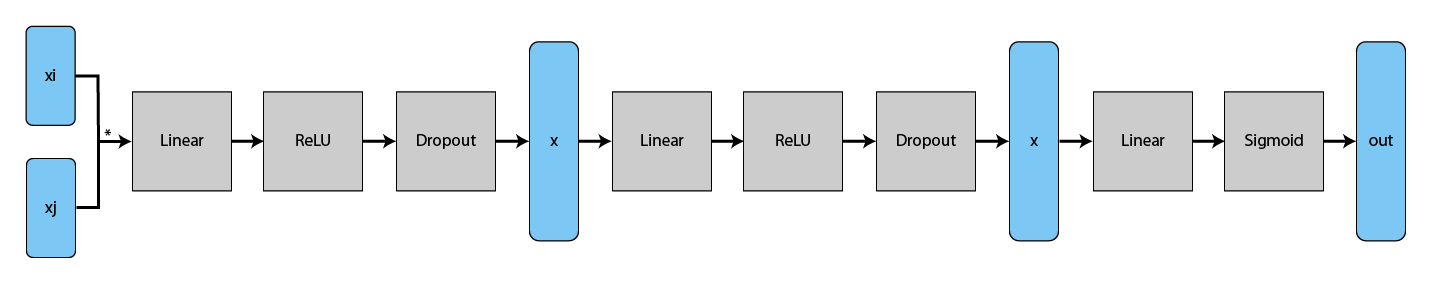

In the constructor we define layers of our MLP, which are simply `Linear` transformations with `bias=True` that we have already used.

In the `forward` method we implement the forward pass. We are given 2 tensors, which represent embeddings of both ends of edges. To get probability for edges, we first multiply node embeddings element wise to get the first layer edge embeddings. We then feed these embeddings through our MLP layers in which we are also using ReLU activation function and dropout. On the last layer we only do a `Linear` transformation and use `sigmoid` function to produce valid probabilities.

In [ ]:
class MLP(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
    super().__init__()

    self.num_layers = num_layers

    # Dropout probability
    self.dropout = dropout

    self.convs = torch.nn.ModuleList()
    # Add first layer
    self.convs.append(Linear(input_dim, hidden_dim, True))
    # Add hidden layers
    for _ in range(num_layers - 2):
      self.convs.append(Linear(hidden_dim, hidden_dim, True))
    # Add last layers
    self.convs.append(Linear(hidden_dim, output_dim, True))

    self.reset_parameters()
  
  def reset_parameters(self):
    for conv in self.convs:
      conv.reset_parameters()

  def forward(self, x_i, x_j):
    x = x_i * x_j

    for i in range(self.num_layers - 1):
      x = self.convs[i](x)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.convs[-1](x)

    # Return number from 0 to 1 for every edge
    return torch.sigmoid(x)

### Test function

Before our test function we need to use `no_grad` decorator to turn off gradient computation as it is not needed during testing. Then we switch to **evaluation mode** with a call of `eval` on our models. This acts as a switch for layers that behave differently during training and evaluation(i.e. dropout).

Next we need to get node embeddings, which we do using `model` which is our `GNN` object. We feed it node embeddings, `x.weight` and graph data `graph.adj_t`. We also set `K` parameter to 20 for our evaluator.

To be able to compute accuracy we need edge predictions for different subsets(valid, test and train). Valid and test are computed exactly the same with the exception of set names. We take into consideration positive and negative edges.
From `split_edge` we simply take the edges for which we want to calculate embeddings and feed their nodes into edge prediction model `edge_model`. The result is a 1D tensor of probabilities that we put into `eval` function of our evaluator which is provided by OGB. Because we do not have training negative edges, we use the ones from valid split to obtain a train accuracy measure.

At the end we just return accuracy measure hits@20 that are calculated by `evaluator`.

In [ ]:
@torch.no_grad()
def test(evaluator, model, edge_model, split_edge, x, graph):
  model.eval()
  edge_model.eval()

  # Forward propagation to obtain node embeddings
  embeddings = model(x.weight, graph.adj_t)

  evaluator.K = 20;

  # Get edge predictions for valid edges
  positive_valid_edges = split_edge['valid']['edge'].t().to(device)
  predictions_valid_pos = edge_model(embeddings[positive_valid_edges[0]],
                                 embeddings[positive_valid_edges[1]])
  negative_valid_edges = split_edge['valid']['edge_neg'].t().to(device)
  predictions_valid_neg = edge_model(embeddings[negative_valid_edges[0]],
                                 embeddings[negative_valid_edges[1]])

  valid_hits = evaluator.eval({
    'y_pred_pos': predictions_valid_pos.flatten(),
    'y_pred_neg': predictions_valid_neg.flatten(),
  })['hits@20']

  # Get edge predictions for test edges
  positive_test_edges = split_edge['test']['edge'].t().to(device)
  predictions_test_pos = edge_model(embeddings[positive_test_edges[0]],
                                 embeddings[positive_test_edges[1]])
  negative_test_edges = split_edge['test']['edge_neg'].t().to(device)
  predictions_test_neg = edge_model(embeddings[negative_test_edges[0]],
                                 embeddings[negative_test_edges[1]])

  test_hits = evaluator.eval({
    'y_pred_pos': predictions_test_pos.flatten(),
    'y_pred_neg': predictions_test_neg.flatten(),
  })['hits@20']

  # Get edge predictions for a subset of train edges
  positive_train_edges = split_edge['train_acc']['edge'].t().to(device)
  predictions_train_pos = edge_model(embeddings[positive_train_edges[0]],
                                 embeddings[positive_train_edges[1]])

  train_hits = evaluator.eval({
    'y_pred_pos': predictions_train_pos.flatten(),
    'y_pred_neg': predictions_valid_neg.flatten(),
  })['hits@20']

  return train_hits, valid_hits, test_hits


### Train function

Our `train` function will build all the models and train them using given parameters.

We first get positive train edges from graph splits which we will use in training. For negative sampling we need an edge index, which we obtain from our graph data.

Then we create our models. The first one, `model`, will generate node embeddings, and `edge_model` will create edge predictions. We need to make sure both of them are on the device we are currently using, which is stored in `device` variable. Because we want edge predictor to generate probabilities, we make sure to make its output dimension 1.

As this graph does not have any node features, we will use `torch.nn.Embedding` class to create learnable features. As with the models, we move them to the appropriate device.

Evaluator is provided by Open Graph Benchmark and we create the specific one for our database using `Evaluator(name='ogbl-ddi')`. For the optimizer we will be using Adam optimizer. It will optimize parameters for both of our models, as well as node features which we will learn.

Now we run the training for a specific number of epochs. For every epoch we will calculate the loss which we will print at the end of it. First we make sure our models are in train mode using `train` method call. Then we create a loader for our graph, which will create mini-batches for us.

For every mini-batch we will calculate the loss, add it to the total current epoch loss and optimize parameters. First we zero out our optimizer. Then we do a forward pass on our `model` and get positive edges for the current mini-batch using `perm`, which is a tensor containing indexes of edges for the current mini-batch. To get negative edges we use `negative_sampling` function from PyTorch Geometric.

After obtaining node embeddings, positive and negative edges, we create edge probabilites for our selected edges. We want probabilities to be high for positive and low for negative edges. To achieve this we will be minimizing Binary Cross Entropy:
$$
\mathcal L = - \frac{1}{N} \sum \left[ y_i \cdot \log(\hat y_i) + (1 - y_i) \cdot \log(1 - \hat y_i) \right] ,
$$
where $\hat y_i$ is $i$-th edge predicted probability and $y_i$ is 1 for positive edges and 0 for negative ones. 

At the end of epoch, we divide the total loss by number of edges, to get loss per edge and call `test` function to obtain train, valid and test accuracies.



In [ ]:
from torch_geometric.data import DataLoader
from torch_sparse import SparseTensor
from torch_geometric.utils import negative_sampling

def train(
    graph, splits, epochs, batch_size, input_dim, hidden_dim, output_dim,
    num_layers, dropout, learning_rate, device
  ):

  positive_train_edges = splits['train']['edge'].to(device)
  row, col, _ = graph.adj_t.coo()
  edge_index = torch.stack([col, row], dim=0)

  # Create model
  model = GNN(input_dim, hidden_dim, output_dim, num_layers, dropout).to(device)
  edge_model = MLP(output_dim, output_dim // 2, 1, num_layers, dropout).to(device)

  # Create learnable features
  x = torch.nn.Embedding(graph.num_nodes, input_dim).to(device)

  evaluator = Evaluator(name='ogbl-ddi')

  # Create optimizer
  adam = torch.optim.Adam(
      list(model.parameters()) + list(x.parameters()) + list(edge_model.parameters()),
      lr=learning_rate)

  for epoch in range(1, 1 + epochs):
    total_loss = 0

    model.train()
    edge_model.train()

    # Create loader for mini batching
    loader = DataLoader(range(positive_train_edges.size(0)), batch_size, shuffle=True)

    # Process every batch
    for perm in loader:
      adam.zero_grad()

      # Forward pass
      embeddings = model(x.weight, graph.adj_t)

      # Get batch positive and negative edges
      batch_edges = positive_train_edges[perm].t()
      neg_edges = negative_sampling(edge_index, num_nodes=graph.num_nodes,
                                    num_neg_samples=perm.size(0), method='dense')

      # Predict edges using MLP
      batch_predictions = edge_model(embeddings[batch_edges[0]], embeddings[batch_edges[1]])
      neg_predictions = edge_model(embeddings[neg_edges[0]], embeddings[neg_edges[1]])

      # Calculate loss (BCE)
      pos_loss = -torch.log(batch_predictions + 1e-15).mean() 
      neg_loss = -torch.log(1 - neg_predictions + 1e-15).mean() 

      loss = pos_loss + neg_loss
      total_loss += batch_edges.size()[1] * loss

      # Backpropagate
      loss.backward()
      adam.step()

    total_loss /= positive_train_edges.size(0) 

    train_hits, valid_hits, test_hits = test(evaluator, model, edge_model, splits, x, graph)
    print(f'Epoch: {epoch}, Loss: {total_loss:.3f}, '
           f'Train hits@20: {100 * train_hits:.2f}%, '
           f'Valid hits@20: {100 * valid_hits:.2f}%, '
           f'Test hits@20: {100 * test_hits:.2f}%')
    
  return valid_hits, test_hits


### Training

Now we run our model training using the parameters we have defined at the beggining. We run the training multiple times and save the best model results.

In [ ]:
best_valid, best_test = 0, 0

for run in range(1, RUNS + 1):
  print(f'Run: {run}')
  curr_valid, curr_test = train(graph, split_edge, EPOCHS, BATCH_SIZE, INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM,
      NUM_LAYERS, DROPOUT, LEARNING_RATE, device)
  if curr_test > best_test:
    best_valid, best_test = curr_valid, curr_test
  print('-' * 50)


## Best results

In [ ]:
print(f'Best model valid accuracy: {100 * best_valid:.2f}%')
print(f'Best model test accuracy: {100 * best_test:.2f}%')